In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import integrate
import scipy.integrate as integrate
from tqdm import tqdm
import statistics
import corner

In [152]:
df = pd.DataFrame(pd.read_csv(r'catalogue_out.csv'))
print(df)

    Unnamed: 0    zb_dl  zb_true_dl      dlb_dl   dlberr_dl
0            0  0.12125     0.12052   581.51438   10.472995
1            1  0.21121     0.21044  1074.33456   12.967163
2            2  0.37076     0.37055  2053.61703   64.216697
3            3  0.25726     0.25884  1367.00135   66.805290
4            4  0.09996     0.09821   478.33361   60.393946
..         ...      ...         ...         ...         ...
90          90  0.25659     0.25687  1367.00135  126.242450
91          91  0.09263     0.09014   427.64956   12.474550
92          92  0.12901     0.12979   633.99673   61.574080
93          93  0.23043     0.23075  1189.85641   47.154152
94          94  0.32962     0.33014  1797.47822   35.536180

[95 rows x 5 columns]


In [153]:
df.sort_values(["zb_dl"],axis=0, ascending=True,inplace=True,na_position='first')
print(df)

    Unnamed: 0    zb_dl  zb_true_dl      dlb_dl   dlberr_dl
30          30  0.00896     0.00981    44.89369    1.083196
38          38  0.04918     0.05000   231.12517    2.651061
21          21  0.06009     0.06003   279.30983   11.529917
27          27  0.08914     0.08840   427.64956   41.251119
91          91  0.09263     0.09014   427.64956   12.474550
..         ...      ...         ...         ...         ...
25          25  0.36800     0.37174  2053.61703  119.397467
2            2  0.37076     0.37055  2053.61703   64.216697
71          71  0.37119     0.36623  2053.61703  169.444186
28          28  0.37878     0.37927  2118.74751   86.423812
88          88  0.38868     0.38863  2184.30519   66.599612

[95 rows x 5 columns]


In [154]:
data_z_err = df['zb_dl'].to_numpy()
data_z = df['zb_true_dl'].to_numpy()
data_dl = df['dlb_dl'].to_numpy()
delta_dl = df['dlberr_dl'].to_numpy()

delta_z = np.absolute(data_z-data_z_err)

Text(0.5, 0, '$z$')

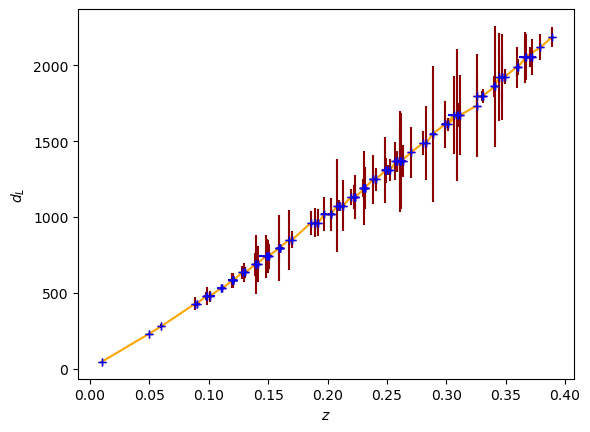

In [155]:
plt.plot(data_z,data_dl, color="orange")
plt.errorbar(data_z, data_dl, yerr=delta_dl,fmt ='+', color="darkred")
plt.errorbar(data_z, data_dl, xerr=delta_z,fmt ='+', color="blue")
plt.ylabel("$d_L$")
plt.xlabel("$z$")

In [156]:
def llike(data_dl, data_z, H0_prop, omega_prop, delta_dl, N_obs):
    
    c = 3e5

    func = 1/(np.sqrt(omega_prop*((data_z+1)**3)+1-omega_prop))
    
    integ = integrate.cumtrapz(func, data_z, initial = 0) 
    
    init_point = 0.5*data_z[0]*(func[0] + 1)
    first_term = -(N_obs/2) * np.log(2 * np.pi) - np.log(np.prod(delta_dl))
    second_term = -np.sum((1/(2 * delta_dl**2)) * (data_dl - ((c/H0_prop)*((1+data_z)*(integ + init_point))))**2)
    

    return(first_term + second_term)

In [157]:
def lprior_uniform(param, param_low_val, param_high_val):
    """
    Set uniform priors on parameters with select ranges.
    """
    if param < param_low_val or param > param_high_val:
        return -np.inf
    else:
        return 0

In [158]:
def lpost(data_dl, data_z, H0_prop, omega_prop, delta_dl, N_obs, param1, param2, 
          param1_low_range = 0, param1_high_range = 100, 
          param2_low_range = 0, param2_high_range = 10):
    '''
    Compute log posterior - require log likelihood and log prior.
    '''
    return(lprior_uniform(param1, param1_low_range, param1_high_range) 
           +lprior_uniform(param2, param2_low_range, param2_high_range) 
           + llike(data_dl, data_z, H0_prop, omega_prop, delta_dl, N_obs))

In [159]:
def accept_reject(lp_prop, lp_prev):
    '''
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    '''
    u = np.random.uniform(size = 1)  # U[0, 1]
    logalpha = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < logalpha:
        return(1)  # Accept
    else:
        return(0)  # Reject

In [160]:
def MCMC_run(data_dl, data_z, delta_dl, Ntotal, burnin, N_obs, param_start, H0_var_prop, omega_var_prop, printerval):
    '''
    Metropolis MCMC sampler
    '''

    # Set starting values

    H0_chain = [param_start[0]]
    omega_chain = [param_start[1]]
                                           
    # Initial value for log posterior
    lp = []
    lp.append(lpost(data_dl, data_z, H0_chain[0], omega_chain[0], delta_dl, N_obs, H0_chain[0], omega_chain[0])) # Append first value of log posterior 
    
    lp_store = lp[0]  # Create log posterior storage to be overwritten

    #####                                                  
    # Run MCMC
    #####
    accept_reject_count = [1]

    for i in tqdm(range(1, Ntotal)):
        
        if i % printerval == 0: # Print accept/reject ratio.
            # tqdm.write("Iteration ", i, "accept_reject =",sum(accept_reject_count)/len(accept_reject_count))
            accept_reject_ratio = sum(accept_reject_count)/len(accept_reject_count)
            tqdm.write("Iteration {0}, accept_reject = {1}".format(i,accept_reject_ratio))
            # print("Iteration ", i, "accept_reject =",sum(accept_reject_count)/len(accept_reject_count))
            
        lp_prev = lp_store  # Call previous stored log posterior
        
        # Propose new points according to a normal proposal distribution of fixed variance 
        
        H0_prop = np.random.normal(H0_chain[i - 1], np.sqrt(H0_var_prop))
        omega_prop = np.random.normal(omega_chain[i - 1], np.sqrt(omega_var_prop))
#         omega_prop = 0.3
        # Compute log posterior
        lp_prop = lpost(data_dl, data_z, H0_prop, omega_prop, delta_dl, N_obs, H0_prop, omega_prop)
        
        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            H0_chain.append(H0_prop)    # accept H0_{prop} as new sample
            omega_chain.append(omega_prop)      # accept omega_{prop} as new sample
            accept_reject_count.append(1)
            lp_store = lp_prop  # Overwrite lp_store
            
        else:  # Reject, if this is the case we use previously accepted values
            H0_chain.append(H0_chain[i - 1])
            omega_chain.append(omega_chain[i - 1])
            accept_reject_count.append(0)

        lp.append(lp_store)
    
    # Recast as np.arrays

    H0_chain = np.array(H0_chain)
    omega_chain = np.array(omega_chain)
    
    H0_chain = H0_chain[burnin:]
    omega_chain = omega_chain[burnin:]

    
    return H0_chain, omega_chain, lp  # Return chains and log posterior.

In [161]:
param_start =[60, 0.5]
Ntotal = 150000 # Total number of iterations
burnin = 70000  # Set burn-in. This is the amount of samples we will discard whilst looking 
                # for the true parameters
H0_var_prop = 0.540380095833388**2
omega_var_prop = 0.052154731554305084**2
printerval = 100000

N_obs = len(data_z)

In [162]:
H0_chain, omega_chain, lp = MCMC_run(data_dl, data_z, delta_dl, Ntotal, burnin, N_obs,
                           param_start, H0_var_prop, omega_var_prop, printerval)

 70%|█████████████████████████████████████████████████████████▍                        | 105136/149999 [00:06<00:02, 17092.77it/s]

Iteration 100000, accept_reject = 0.35015


100%|██████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:08<00:00, 17148.81it/s]


mean of H0 = 67.24383491928457 _ standard deviation of H0 = 0.5797532350382048
mean of omega = 0.32832204635681456 _ standard deviation of omega = 0.055930733138773045


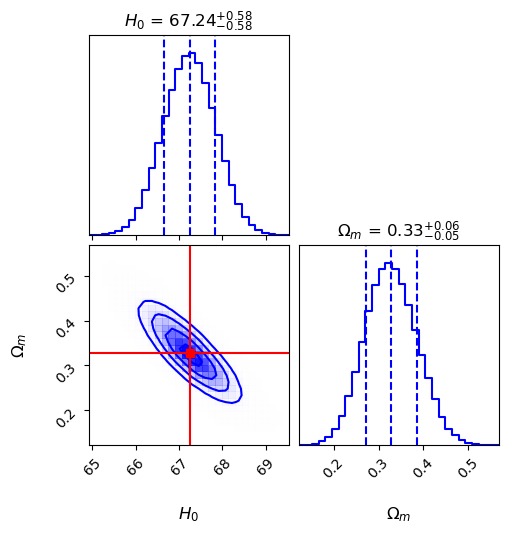

In [163]:
#plt.hist(H0_chain, bins = 60, color = 'turquoise', edgecolor = 'darkcyan', alpha = 0.75)
#plt.hist(omega_chain, bins = 60, color = 'purple', edgecolor = 'rebeccapurple', alpha = 0.75)

ma = statistics.mean(H0_chain)
sda = statistics.stdev(H0_chain)

mb = statistics.mean(omega_chain)
sdb = statistics.stdev(omega_chain)


print("mean of H0 =", ma, '_', "standard deviation of H0 =", sda)
print("mean of omega =", mb, '_', "standard deviation of omega =", sdb)

samples = np.column_stack([H0_chain,omega_chain])

params = [r"$H_0$", r"$\Omega_m$"]

figure = corner.corner(samples, bins = 30, color = 'blue', labels = params, 
                plot_datapoints = False, smooth1d = True, smooth = True, quantiles=[0.16, 0.5, 0.84],
                show_titles = True, label_kwargs = {"fontsize":12}, title_fmt='.2f',title_kwargs={"fontsize": 12})

axes = np.array(figure.axes).reshape((2, 2))

m = [ma, mb]

for yi in range(2):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(m[xi], color="r")
        ax.axhline(m[yi], color="r")
        ax.plot(m[xi], m[yi], "sr")

In [131]:
data_z = data_z[:90]
data_dl = data_dl[:90]
delta_dl = delta_dl[:90]
data_z_err = data_z_err[:90]
delta_z = delta_z[:90]